# Get multibolid data



In [3]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [4]:
multibolid_id = 1504570

In [5]:
bz = Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 7


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [6]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['url_file', 'namesimple', 'filepath', 'url_station', 'id_observer', 'file_status', 'event_id', 'url_file_raw', 'url_file_js9', 'observatory_name', 'observatory_namesimple', 'peak_f', 'magnitude', 'station_name', 'duration', 'filename_raw', 'id_server', 'obstime', 'filename', 'noise']

{'url_file': 'http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12/20170925124803089_OBSUPICE-R6_met.fits', 'namesimple': 'OBSUPICE-R6', 'filepath': '/storage/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12', 'url_station': 'http://api.vo.astro.cz/bolidozor/getStation/?id=25', 'id_observer': 25, 'file_status': 'online', 'event_id': 898892, 'url_file_raw': 'http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12/20170925124803089_OBSUPICE-R6_raws.fits', 'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12/20170925124803089_OBSUPICE-R6_met.fits', 'observatory_name': 'Hvězdárna v Úpici', 'obse

Nahrát data do cache

In [7]:
for i, bolid in enumerate(bolids.result):
    print(i+1,'z',len(bolids.result))
    fits.open(bolid['url_file_raw'])

1 z 7
2 z 7
3 z 7
4 z 7
5 z 7
6 z 7
7 z 7


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [8]:
def timeCalibration(raw_file, sigma = 10, debug = True):
    calibration_data = {}
    hdulist = fits.open(raw_file, cache=True)
    met_data = np.abs(np.ravel(hdulist[0].data))
    clip_val = np.std(met_data)*sigma
    plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    for i, point in enumerate(met_data):
        if point > clip_val:
            plt.axvline(x=i, color='red')
            ten_sec = 10/(hdulist[0].header['CDELT2']/2/1000.0)
            if debug: plt.axvline(x=i+ten_sec, color='green')
            break
    #file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    file_length = hdulist[0].header['NAXIS2']*1/96000
    time_firstGPS = i/2*1/96000
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    DATE = datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" )
    
    gps = (DATE-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
    round_gps = round(gps/10.0)*10
    correction = datetime.timedelta(seconds=round_gps-gps)

    calibration_data['sys_correction'] = correction
    
    calibration_data['sys_file_beg'] = DATE-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE
    calibration_data['sys_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE+correction
    calibration_data['cor_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    calibration_data['cor_error'] = correction
    
    if debug:
        #DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni vzorku s GPS :', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', correction)
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        plt.plot(met_data)
        plt.show()
    return calibration_data
        

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

Pokud je zapnuté debugování, tak ze skriptu vypadávají tato data:

delka zaznamu          : Délka záznamu
cas prvni vzorku s GPS : 
cas 1. GPS a konec     : Vzdálenost první detekované GPS ke konci souboru
SysCas ukladani souboru: Čas z hlavičky FITSu ['DATE']
SysCas zacatku souboru : Čas z hlavičky ['DATE'] mínus délka souboru
SysCas 1. GPS znacky   : Systémový čas stanice v okamžiku GPS značky
Korekce systémoveho čas: Systémový čas 
CorCas ukladani souboru: 2017-09-23 07:24:19.241618 s
CorCas zacatku souboru : 2017-09-23 07:24:06.241614
CorCas 1. GPS znacky   : 2017-09-23 07:24:10

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12/20170925124803089_OBSUPICE-R6_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/25/12/20170925124803089_OBSUPICE-R6_raws.fits
delka zaznamu          : 10.4 s
cas prvni vzorku s GPS : 10.399994791666666 s
cas 1. GPS a konec     : 5.2083333343944105e-06 s
SysCas ukladani souboru: 2017-09-25 12:48:39 s
SysCas zacatku souboru : 2017-09-25 12:48:28.600000
SysCas 1. GPS znacky   : 2017-09-25 12:48:38.999995
Korekce systémoveho čas: 0:00:01.000005
CorCas ukladani souboru: 2017-09-25 12:48:40.000005 s
CorCas zacatku souboru : 2017-09-25 12:48:29.600005
CorCas 1. GPS znacky   : 2017-09-25 12:48:40


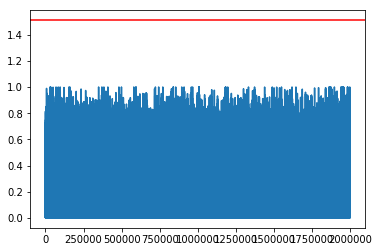

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/nachodsko/NACHODSKO-R5/meteors/2017/09/25/12/20170925124839715_NACHODSKO-R5_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/nachodsko/NACHODSKO-R5/meteors/2017/09/25/12/20170925124839715_NACHODSKO-R5_raws.fits
delka zaznamu          : 12.6 s
cas prvni vzorku s GPS : 12.599994791666667 s
cas 1. GPS a konec     : 5.208333332618054e-06 s
SysCas ukladani souboru: 2017-09-25 12:48:41 s
SysCas zacatku souboru : 2017-09-25 12:48:28.400000
SysCas 1. GPS znacky   : 2017-09-25 12:48:40.999995
Korekce systémoveho čas: -1 day, 23:59:59.000005
CorCas ukladani souboru: 2017-09-25 12:48:40.000005 s
CorCas zacatku souboru : 2017-09-25 12:48:27.400005
CorCas 1. GPS znacky   : 2017-09-25 12:48:40


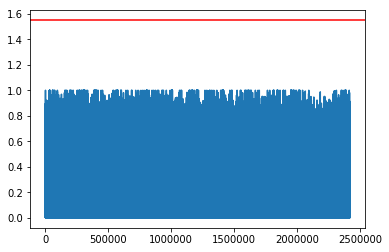

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/25/12/20170925124907394_CIIRC-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/25/12/20170925124907394_CIIRC-R1_raws.fits
delka zaznamu          : 14.4 s
cas prvni vzorku s GPS : 0.40917708333333336 s
cas 1. GPS a konec     : 13.990822916666668 s
SysCas ukladani souboru: 2017-09-25 12:48:42 s
SysCas zacatku souboru : 2017-09-25 12:48:27.600000
SysCas 1. GPS znacky   : 2017-09-25 12:48:28.009177
Korekce systémoveho čas: 0:00:01.990823
CorCas ukladani souboru: 2017-09-25 12:48:43.990823 s
CorCas zacatku souboru : 2017-09-25 12:48:29.590823
CorCas 1. GPS znacky   : 2017-09-25 12:48:30


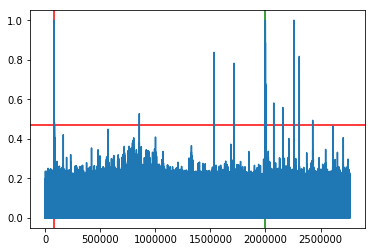

3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/25/12/20170925124901321_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/25/12/20170925124901321_DDMTREBIC-R3_raws.fits
delka zaznamu          : 16.6 s
cas prvni vzorku s GPS : 4.737041666666666 s
cas 1. GPS a konec     : 11.862958333333335 s
SysCas ukladani souboru: 2017-09-25 12:48:45 s
SysCas zacatku souboru : 2017-09-25 12:48:28.400000
SysCas 1. GPS znacky   : 2017-09-25 12:48:33.137042
Korekce systémoveho čas: -1 day, 23:59:56.862958
CorCas ukladani souboru: 2017-09-25 12:48:41.862958 s
CorCas zacatku souboru : 2017-09-25 12:48:25.262958
CorCas 1. GPS znacky   : 2017-09-25 12:48:30


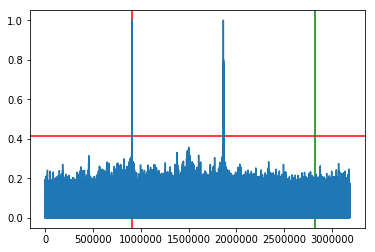

4 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/25/12/20170925124836673_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/25/12/20170925124836673_HFN-R1_raws.fits
delka zaznamu          : 16.6 s
cas prvni vzorku s GPS : 4.80828125 s
cas 1. GPS a konec     : 11.791718750000001 s
SysCas ukladani souboru: 2017-09-25 12:48:46 s
SysCas zacatku souboru : 2017-09-25 12:48:29.400000
SysCas 1. GPS znacky   : 2017-09-25 12:48:34.208281
Korekce systémoveho čas: -1 day, 23:59:55.791719
CorCas ukladani souboru: 2017-09-25 12:48:41.791719 s
CorCas zacatku souboru : 2017-09-25 12:48:25.191719
CorCas 1. GPS znacky   : 2017-09-25 12:48:30


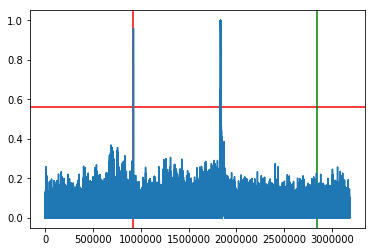

5 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/25/12/20170925124819357_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/25/12/20170925124819357_SVAKOV-R12_raws.fits
delka zaznamu          : 21.8 s
cas prvni vzorku s GPS : 2.02415625 s
cas 1. GPS a konec     : 19.77584375 s
SysCas ukladani souboru: 2017-09-25 12:48:47 s
SysCas zacatku souboru : 2017-09-25 12:48:25.200000
SysCas 1. GPS znacky   : 2017-09-25 12:48:27.224156
Korekce systémoveho čas: 0:00:02.775844
CorCas ukladani souboru: 2017-09-25 12:48:49.775844 s
CorCas zacatku souboru : 2017-09-25 12:48:27.975844
CorCas 1. GPS znacky   : 2017-09-25 12:48:30


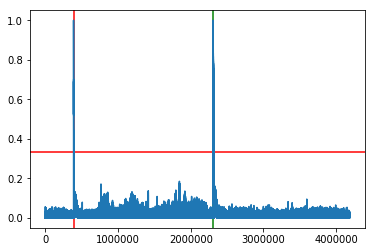

6 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/12/20170925124851578_VALMEZ-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/25/12/20170925124851578_VALMEZ-R1_raws.fits
delka zaznamu          : 20.2 s
cas prvni vzorku s GPS : 0.6308645833333333 s
cas 1. GPS a konec     : 19.569135416666665 s
SysCas ukladani souboru: 2017-09-25 12:48:47 s
SysCas zacatku souboru : 2017-09-25 12:48:26.800000
SysCas 1. GPS znacky   : 2017-09-25 12:48:27.430865
Korekce systémoveho čas: 0:00:02.569135
CorCas ukladani souboru: 2017-09-25 12:48:49.569135 s
CorCas zacatku souboru : 2017-09-25 12:48:29.369135
CorCas 1. GPS znacky   : 2017-09-25 12:48:30


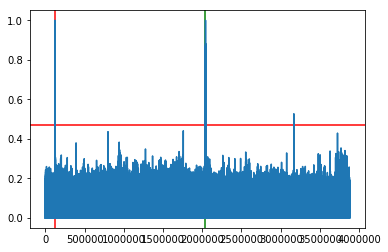

In [9]:

for i, bolid in enumerate(bolids.result):
    print(i,"==================================")
    print("snapshot:", bolid['url_file_js9'])
    bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'])
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [34]:
time_offset = {}
selected = list(range(0, len(bolids.result)))     # vyber vsech dat

selected.remove(0)
selected.remove(1)
#selected.remove(4)
#selected = [0,1,2,3,6]

#selected = [3,4,5,6]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

# time_offset[0] = +0   ## Posun času na stanici.
                        # Timto posunete data pro určitou stanici (podle indexu souboru)
                        # o určitý počet časových značek (10s intervalů)
                        # Kladné číslo posune graf 'nahoru" 
time_offset[3]=0.5
time_offset[4]=0.5
#time_offset[1]=1
for i, bolid in enumerate(bolids.result):
    if i in selected:
        print(i, ',sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['cor_error'], bolid['filename'])

2 ,sysT of gps: 2017-09-25 12:48:30 ,offset: 0:00:01.990823 20170925124907394_CIIRC-R1_met.fits
3 ,sysT of gps: 2017-09-25 12:48:30 ,offset: -1 day, 23:59:56.862958 20170925124901321_DDMTREBIC-R3_met.fits
4 ,sysT of gps: 2017-09-25 12:48:30 ,offset: -1 day, 23:59:55.791719 20170925124836673_HFN-R1_met.fits
5 ,sysT of gps: 2017-09-25 12:48:30 ,offset: 0:00:02.775844 20170925124819357_SVAKOV-R12_met.fits
6 ,sysT of gps: 2017-09-25 12:48:30 ,offset: 0:00:02.569135 20170925124851578_VALMEZ-R1_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

0 2017-09-25 12:48:29.590823
1 2017-09-25 12:48:25.262958
2 2017-09-25 12:48:25.191719
3 2017-09-25 12:48:27.975844
4 2017-09-25 12:48:29.369135
1506343707.975844 1506343729.775844


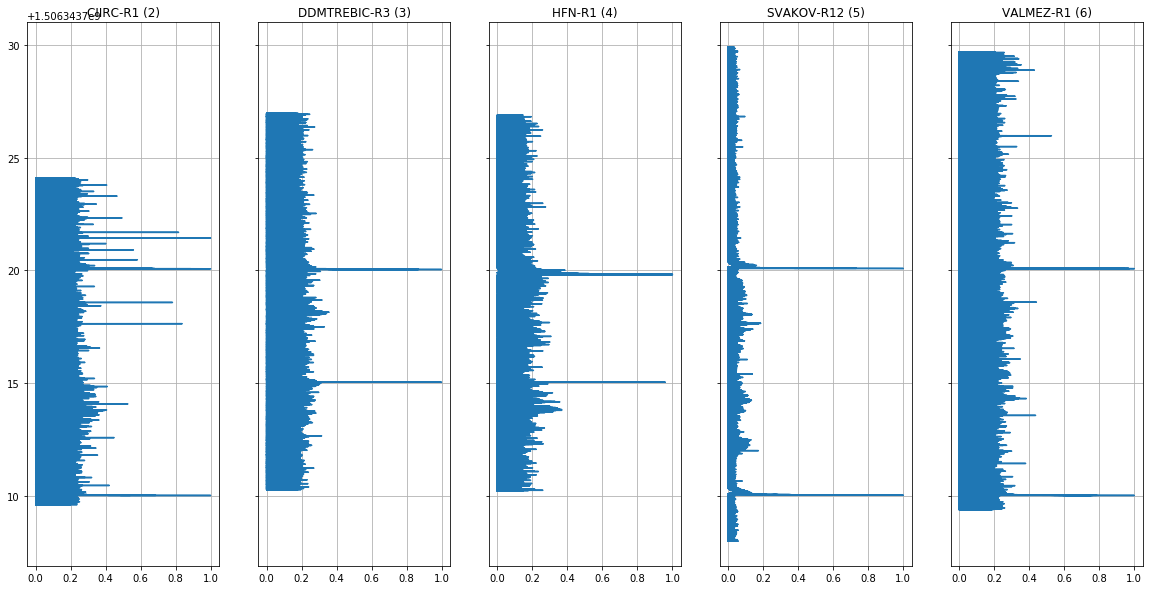

In [35]:
%matplotlib inline 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    print (i, bolid['time_calib']['cor_file_beg'])
    hdulist = fits.open(bolid['url_file_raw'])
    met_data = np.abs(np.ravel(hdulist[0].data))
    
    T_offset = 10*time_offset.get(selected[i], 0)
    
    if gps_calib:
        min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    else:
        min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))
    
    if not minimal_time: minimal_time = min_date
    if not maximal_time: maximal_time = max_date
    if min_date < minimal_time: minimal_time = min_date
    if max_date > maximal_time: maximal_time = max_date
    
    ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+")")
    ax.plot(met_data, array)
    ax.grid(True)

fig.subplots_adjust(hspace=0)
print(minimal_time, maximal_time)

In [36]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

{3: 0.5, 4: 0.5}


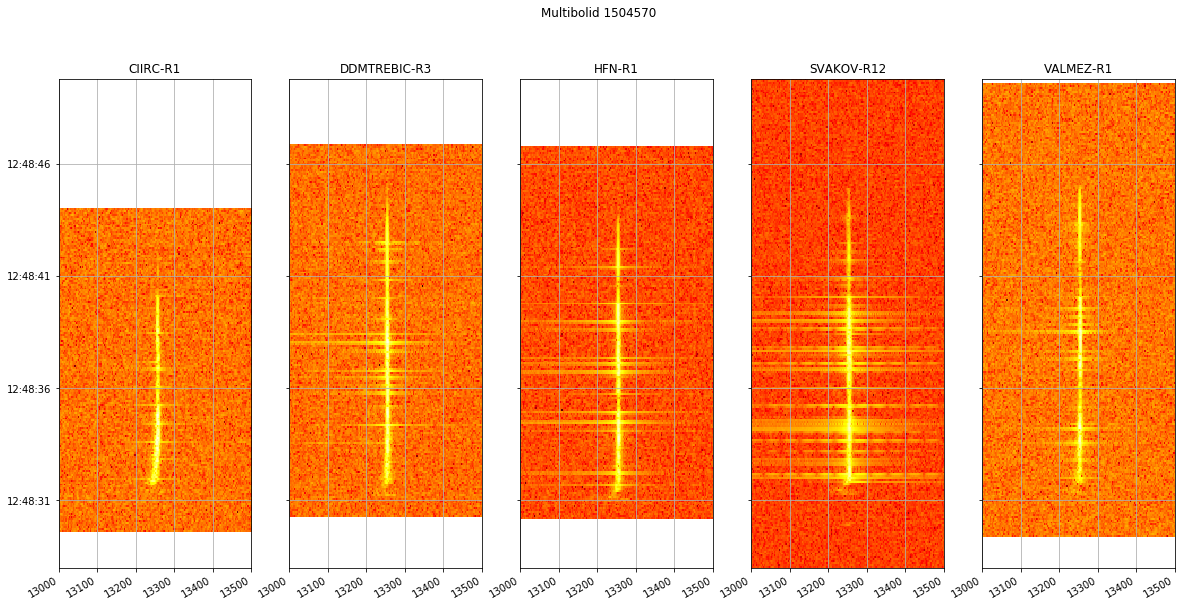

In [37]:
%matplotlib inline 
#%matplotlib notebook
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

print(time_offset)
fig.suptitle("Multibolid %s" %(multibolid_id))
fig.subplots_adjust(hspace=0)
plt.set_cmap('hot')
for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    T_offset = datetime.timedelta(seconds = 10*time_offset.get(selected[i], 0))
    #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
    d1 = bolid['time_calib']['cor_file_beg']+T_offset
    fds1 = dates.date2num(d1) # converted
    d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/48000.0/2)
    fds2 = dates.date2num(d2)
    
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 48000, bins = 4096*4)
    ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-24000, 24000, fds2, fds1])
    ax.grid(True)
    
    ax.set_xlim(13000,13500)
    ax.yaxis_date()
    date_format = md.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))
    
    offset = abs(bolid['time_calib']['cor_error']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
    if bolid['time_calib']['cor_error'] < datetime.timedelta(seconds=0): offset = -offset
    #ax.set_title(bolid['namesimple']+ " err:"+str(offset))
    ax.set_title(bolid['namesimple'])
